# Aligning Deep Exposures of Sparse Fields

<div class="alert-danger">Note: The notebook in this repository 'Initialization.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

# Introduction


This notebook demonstrates aligning long exposures which have relatively few stars and a large number of cosmic rays. It is based on the example described in the ISR linked here ([ACS ISR 2015-04: Basic Use of SExtractor Catalogs With TweakReg - I](http://www.stsci.edu/hst/acs/documents/isrs/isr1504.pdf)), but uses a much simpler methodology.


Rather than making use of external software (e.g. [SExtractor](http://www.astromatic.net/software/sextractor)) and going through the extra steps to create 'cosmic-ray cleaned' images for each visit, this notebook demonstrates new features in TweakReg designed to mitigate false detections.

TweakReg’s source finding task `imagefind` now includes parameters to exclude false detections and allow the software to more easily solve for the image offsets using matched sources lists. For example, `dqbits` is a list of DQ flag values to include as 'good' or to exclude as 'bad' before generating and matching source lists. For ACS/WFC, setting `dqbits=-16` will mask hot pixels flagged by the instrument team, eliminating a common problem where TweakReg locks onto hot pixels and solves for the dither pattern. This can occur when users set the detection threshold value too low and hot pixels outnumber astronomical sources. Other new parameters allow selection for sharpness and roundness, which give users better control over source selection criteria and the mitigation of artifacts. More details on imagefindpars options may be found on the following [webpage](https://drizzlepac.readthedocs.io/en/deployment/imagefindpars.html).

In [1]:
from astropy.table import Table
from astropy.io import fits
from astroquery.mast import Observations
from ccdproc import ImageFileCollection
import glob
import matplotlib.pyplot as plt
import os
import shutil
from drizzlepac import tweakreg
from drizzlepac import astrodrizzle
from IPython.display import Image

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


# 1. Download the Data

The data in this example are comprised of 4 exposures in the F814W filter, all from Visit 0X of HST program 10092. Each exposure was dithered by ~60 pixels along the y-axis in order to obtain coverage in the area of the CCD chip gap. The X and Y dithers are given in arcseconds by the `POSTARG1` and `POSTARG2` keywords recorded in the image header.

The following commands query MAST, download the calibrated, CTE-corrected FLC files, and place them in the same 'working' directory as this notebook. 

In [2]:
# Query MAST for the F814W files.
science_list = Observations.query_criteria(proposal_id='10092', filters='F814W', obs_id='j8xi0x*')
Observations.download_products(science_list['obsid'], mrp_only=False, download_dir='./science',
                               productSubGroupDescription=['FLC'])

science_files = glob.glob('science/mastDownload/HST/*/*fits')
for im in science_files:
    root = im.split('/')[-1]
    os.rename(im, './'+root)
shutil.rmtree('science/')

 [Done]


 [Done]


 [Done]


 [Done]


# 2. Inspect the image headers

In [3]:
collect = ImageFileCollection('./',
                              keywords=["asn_id", "detector", "filter2", "exptime", "postarg1", "postarg2"],
                              glob_include="*flc.fits", ext=0)
out_table = collect.summary
out_table

<Table masked=True length=4>
       file          asn_id  detector filter2 exptime postarg1 postarg2
      str18           str9     str3     str5  float64 float64  float64 
------------------ --------- -------- ------- ------- -------- --------
j8xi0xs0q_flc.fits J8XI0X010      WFC   F814W   507.0    0.062  -3.0518
j8xi0xs3q_flc.fits J8XI0X010      WFC   F814W   507.0     0.31 0.023747
j8xi0xs6q_flc.fits J8XI0X010      WFC   F814W   507.0   -0.062   3.0518
j8xi0xsaq_flc.fits J8XI0X010      WFC   F814W   507.0    0.186 6.127347

# 3. TweakReg Alignment 

Use TweakReg to align the FLC frames based on sources in the image. The provided input list (`input_flc.list`) is used to align the frames in the specified order with `j8xi0xsaq_flc.fits` as the reference image. The parameter `conv_width` specifies the convolution kernel width in pixels, with recommended values ~2x the PSF FWHM for detecting point sources in the FLC frame. For ACS/WFC & WFC3/UVIS, this parameter is typically set to 3.5 pixels and for WFC3/IR to 2.5 pixels, but the value can be increased in order to use compact objects such as small galaxies for alignment.

## 3a. Use 'default' parameters (Test1)

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 15:12:33.670 (10/05/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 15:12:33.670 (10/05/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 7.3.0]


Python Version [GCC 7.3.0]


INFO:drizzlepac.util:3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


INFO:drizzlepac.util:numpy Version -> 1.15.4 


numpy Version -> 1.15.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.4.2 


stwcs Version -> 1.4.2 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	exclusions :	


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	input :	@input_flc.list


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakutils:j8xi0xsaq_flc.fits   


j8xi0xsaq_flc.fits   


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    j8xi0xsaq_flc.fits


    j8xi0xsaq_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs6q_flc.fits


    j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs3q_flc.fits


    j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs0q_flc.fits


    j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	3.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	@input_flc.list


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	100


INFO:drizzlepac.tweakreg:	updatehdr :	False


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.tweakreg:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xsaq_flc.fits':


===  Source finding for image 'j8xi0xsaq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 15:12:33.83 (10/05/2019)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 15:12:33.83 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.082394


INFO:drizzlepac.catalogs:###Source finding finished at: 15:12:34.774 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 8449 objects.


     Found 8449 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 15:12:34.896 (10/05/2019)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 15:12:34.896 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.901318

INFO:drizzlepac.catalogs:###Source finding finished at: 15:12:35.875 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 8582 objects.


     Found 8582 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 17031


===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 17031


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs6q_flc.fits':


===  Source finding for image 'j8xi0xs6q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 15:12:36.261 (10/05/2019)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 15:12:36.261 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.081750


INFO:drizzlepac.catalogs:###Source finding finished at: 15:12:37.173 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 6124 objects.


     Found 6124 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 15:12:37.344 (10/05/2019)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 15:12:37.344 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.046386


INFO:drizzlepac.catalogs:###Source finding finished at: 15:12:38.214 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 6070 objects.


     Found 6070 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 12194


===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 12194


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs3q_flc.fits':


===  Source finding for image 'j8xi0xs3q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 15:12:38.72 (10/05/2019)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 15:12:38.72 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.116258


INFO:drizzlepac.catalogs:###Source finding finished at: 15:12:39.556 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 4621 objects.


     Found 4621 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 15:12:39.653 (10/05/2019)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 15:12:39.653 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.016353


INFO:drizzlepac.catalogs:###Source finding finished at: 15:12:40.515 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 4713 objects.


     Found 4713 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 9334


===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 9334


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs0q_flc.fits':


===  Source finding for image 'j8xi0xs0q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 15:12:40.994 (10/05/2019)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 15:12:40.994 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.574701


INFO:drizzlepac.catalogs:###Source finding finished at: 15:12:41.822 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 4884 objects.


     Found 4884 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 15:12:41.917 (10/05/2019)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 15:12:41.917 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.441343


INFO:drizzlepac.catalogs:###Source finding finished at: 15:12:42.802 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 5267 objects.


     Found 5267 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 10151


===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 10151


INFO:drizzlepac.imgclasses:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "j8xi0xsaq_flc.fits" to X,Y positions in reference WCS...


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'j8xi0xsaq_flc.fits'


derived from 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	searchrad :	1.0


INFO:drizzlepac.tweakreg:	searchunits :	arcseconds


INFO:drizzlepac.tweakreg:	see2dplot :	True


INFO:drizzlepac.tweakreg:	separation :	0.5


INFO:drizzlepac.tweakreg:	tolerance :	1.0


INFO:drizzlepac.tweakreg:	use2dhist :	True


INFO:drizzlepac.tweakreg:	xoffset :	0.0


INFO:drizzlepac.tweakreg:	yoffset :	0.0


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:


INFO:drizzlepac.tweakreg:	fitgeometry :	rscale


INFO:drizzlepac.tweakreg:	labelsize :	8


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	nclip :	3


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	sigma :	3.0


INFO:drizzlepac.tweakreg:	ylimit :	0.4


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:


INFO:drizzlepac.tweakreg:	outshifts :	shift814_flc_test1.txt


INFO:drizzlepac.tweakreg:	outwcs :	shifts_wcs.fits


INFO:drizzlepac.tweakreg:	shiftfile :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs6q_flc.fits


Performing fit for: j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.08095952023987962 -1.0299850074962507


Found initial X and Y shifts of  -0.08095952023987962 -1.0299850074962507


INFO:drizzlepac.tweakutils:    with significance of  535.084843247951 and  43.0  matches


    with significance of  535.084843247951 and  43.0  matches


INFO:drizzlepac.imgclasses:Found 152 matches for j8xi0xs6q_flc.fits...


Found 152 matches for j8xi0xs6q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.0230  YSH: -0.7217    ROT: 0.001987304867    SCALE: 0.999940


XSH: -0.0230  YSH: -0.7217    ROT: 0.001987304867    SCALE: 0.999940


INFO:drizzlepac.imgclasses:XRMS: 0.62    YRMS: 0.71


XRMS: 0.62    YRMS: 0.71


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.1e-05 (deg)   RMS_DEC: 6.7e-06 (deg)


RMS_RA: 1.1e-05 (deg)   RMS_DEC: 6.7e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  152  objects.


Final solution based on  152  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs6q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  152


Total # points:  152


INFO:drizzlepac.tweakutils:# of points after clipping:  152


# of points after clipping:  152


INFO:drizzlepac.tweakutils:Total # points:  152


Total # points:  152


INFO:drizzlepac.tweakutils:# of points after clipping:  152


# of points after clipping:  152


INFO:drizzlepac.updatehdr:....Updating header for j8xi0xs6q_flc.fits...


INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',2]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[4]


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs3q_flc.fits


Performing fit for: j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.21722113502935514 -0.9843444227005875


Found initial X and Y shifts of  -0.21722113502935514 -0.9843444227005875


INFO:drizzlepac.tweakutils:    with significance of  505.4141650773844 and  37.0  matches


    with significance of  505.4141650773844 and  37.0  matches


INFO:drizzlepac.imgclasses:Found 116 matches for j8xi0xs3q_flc.fits...


Found 116 matches for j8xi0xs3q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.1846  YSH: -0.6921    ROT: 359.9951865    SCALE: 0.999931


XSH: -0.1846  YSH: -0.6921    ROT: 359.9951865    SCALE: 0.999931


INFO:drizzlepac.imgclasses:XRMS: 0.61    YRMS: 0.72


XRMS: 0.61    YRMS: 0.72


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.1e-05 (deg)   RMS_DEC: 6.6e-06 (deg)


RMS_RA: 1.1e-05 (deg)   RMS_DEC: 6.6e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  116  objects.


Final solution based on  116  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs3q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  116


Total # points:  116


INFO:drizzlepac.tweakutils:# of points after clipping:  116


# of points after clipping:  116


INFO:drizzlepac.tweakutils:Total # points:  116


Total # points:  116


INFO:drizzlepac.tweakutils:# of points after clipping:  116


# of points after clipping:  116


INFO:drizzlepac.updatehdr:....Updating header for j8xi0xs3q_flc.fits...


INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',1]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',2]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[4]


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs0q_flc.fits


Performing fit for: j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  0.06422018348623837 -0.9486238532110107


Found initial X and Y shifts of  0.06422018348623837 -0.9486238532110107


INFO:drizzlepac.tweakutils:    with significance of  282.7861382741382 and  49.0  matches


    with significance of  282.7861382741382 and  49.0  matches


INFO:drizzlepac.imgclasses:Found 134 matches for j8xi0xs0q_flc.fits...


Found 134 matches for j8xi0xs0q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.1585  YSH: -0.6700    ROT: 359.9992648    SCALE: 0.999989


XSH: 0.1585  YSH: -0.6700    ROT: 359.9992648    SCALE: 0.999989


INFO:drizzlepac.imgclasses:XRMS: 0.67    YRMS: 0.76


XRMS: 0.67    YRMS: 0.76


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.2e-05 (deg)   RMS_DEC: 7.3e-06 (deg)


RMS_RA: 1.2e-05 (deg)   RMS_DEC: 7.3e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  134  objects.


Final solution based on  134  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs0q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  134


Total # points:  134


INFO:drizzlepac.tweakutils:# of points after clipping:  134


# of points after clipping:  134


INFO:drizzlepac.tweakutils:Total # points:  134


Total # points:  134


INFO:drizzlepac.tweakutils:# of points after clipping:  134


# of points after clipping:  134


INFO:drizzlepac.updatehdr:....Updating header for j8xi0xs0q_flc.fits...


INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',1]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',2]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[4]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.tweakutils:Writing out shiftfile : shift814_flc_test1.txt


Writing out shiftfile : shift814_flc_test1.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


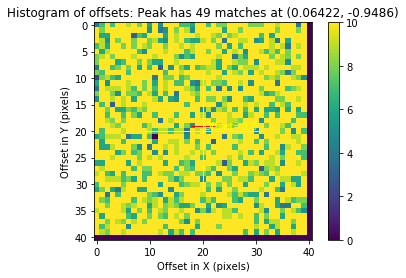

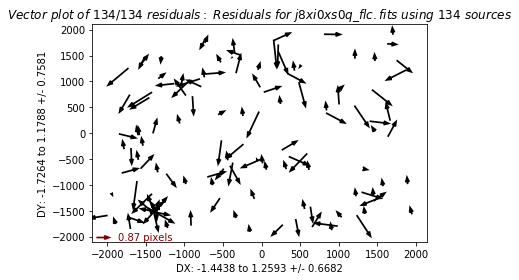

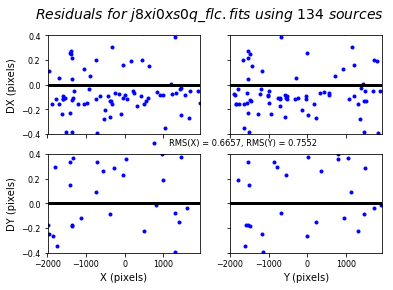

In [4]:
tweakreg.TweakReg('@input_flc.list',
                  imagefindcfg={'threshold': 100,'conv_width': 3.5},
                  shiftfile=True, outshifts='shift814_flc_test1.txt',
                  updatehdr=False, interactive=False, ylimit=0.4)

In [5]:
# Give the 'fit residual plots' a unique name for comparison with other tests.
residual_pngs = glob.glob("residual*png")
for png in residual_pngs: 
    path = os.path.abspath(os.path.join(os.curdir, png))
    new_path = os.path.abspath(os.path.join(os.curdir, 'test1_{}'.format(png)))
    os.rename(path, new_path)

To verify that TweakReg has found a good fit, it is important to inspect the fit residuals. Below are the dx,dy residuals for each FLC file with respect to the reference image `j8xi0xsaq_flc.fits`. TweakReg finds >100 matches per frame, but the RMS of the fit residuals is quite large, ~0.7 pixels, and the points are not nicely clustered around dx,dy=0.0, as expected for a good fit.

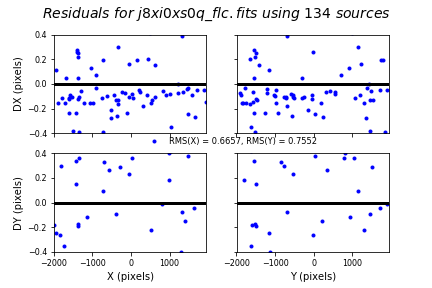

In [6]:
Image(filename='test1_residuals_j8xi0xs0q_flc.png')

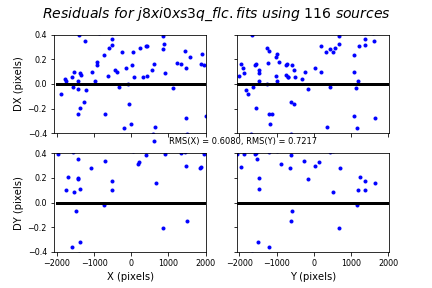

In [7]:
Image(filename='test1_residuals_j8xi0xs3q_flc.png')

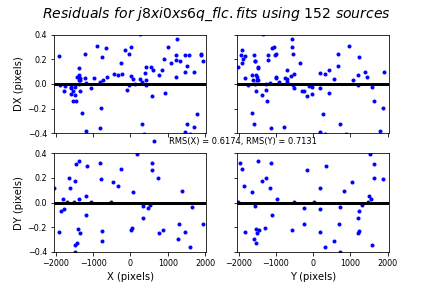

In [8]:
Image(filename='test1_residuals_j8xi0xs6q_flc.png')

In [9]:
# Inspect the shift file for Test1
shift_table = Table.read('shift814_flc_test1.txt', format='ascii.no_header',
               names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1: ]):
    shift_table[col].format = formats[i]
shift_table

<Table length=4>
       file           dx      dy     rot    scale    xrms    yrms 
      str18        float64 float64 float64 float64 float64 float64
------------------ ------- ------- ------- ------- ------- -------
j8xi0xsaq_flc.fits    0.00    0.00   0.000 1.00000    0.00    0.00
j8xi0xs6q_flc.fits   -0.02   -0.72   0.002 0.99994    0.62    0.71
j8xi0xs3q_flc.fits   -0.18   -0.69 359.995 0.99993    0.61    0.72
j8xi0xs0q_flc.fits    0.16   -0.67 359.999 0.99999    0.67    0.76

## 3b. Adjust `conv_width` to find extended objects (Test 2)

In order for TweakReg to use compact galaxies rather than point sources for alignment, we increase the convolution kernel width parameter `conv_width` from 3.5 to 6.0 pixels in order to find sources with a FWHM ~3 pixels in the FLC frames.

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 15:12:46.887 (10/05/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 15:12:46.887 (10/05/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 7.3.0]


Python Version [GCC 7.3.0]


INFO:drizzlepac.util:3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


INFO:drizzlepac.util:numpy Version -> 1.15.4 


numpy Version -> 1.15.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.4.2 


stwcs Version -> 1.4.2 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	exclusions :	


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	input :	@input_flc.list


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakutils:j8xi0xsaq_flc.fits   


j8xi0xsaq_flc.fits   


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    j8xi0xsaq_flc.fits


    j8xi0xsaq_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs6q_flc.fits


    j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs3q_flc.fits


    j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs0q_flc.fits


    j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	6.0


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	@input_flc.list


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	100


INFO:drizzlepac.tweakreg:	updatehdr :	False


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.tweakreg:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xsaq_flc.fits':


===  Source finding for image 'j8xi0xsaq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 15:12:47.053 (10/05/2019)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 15:12:47.053 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.082394


INFO:drizzlepac.catalogs:###Source finding finished at: 15:12:48.129 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 2697 objects.


     Found 2697 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 15:12:48.217 (10/05/2019)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 15:12:48.217 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.901318


INFO:drizzlepac.catalogs:###Source finding finished at: 15:12:49.22 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 2634 objects.


     Found 2634 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 5331


===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 5331


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs6q_flc.fits':


===  Source finding for image 'j8xi0xs6q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 15:12:49.558 (10/05/2019)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 15:12:49.558 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.081750


INFO:drizzlepac.catalogs:###Source finding finished at: 15:12:50.529 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 1841 objects.


     Found 1841 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 15:12:50.611 (10/05/2019)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 15:12:50.611 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.046386


INFO:drizzlepac.catalogs:###Source finding finished at: 15:12:51.553 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 1847 objects.


     Found 1847 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 3688


===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 3688


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs3q_flc.fits':


===  Source finding for image 'j8xi0xs3q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 15:12:51.809 (10/05/2019)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 15:12:51.809 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.116258


INFO:drizzlepac.catalogs:###Source finding finished at: 15:12:52.767 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 1350 objects.


     Found 1350 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 15:12:52.845 (10/05/2019)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 15:12:52.845 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.016353


INFO:drizzlepac.catalogs:###Source finding finished at: 15:12:53.741 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 1396 objects.


     Found 1396 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 2746


===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 2746


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs0q_flc.fits':


===  Source finding for image 'j8xi0xs0q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 15:12:54.004 (10/05/2019)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 15:12:54.004 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.574701

INFO:drizzlepac.catalogs:###Source finding finished at: 15:12:54.940 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 1475 objects.


     Found 1475 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 15:12:55.019 (10/05/2019)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 15:12:55.019 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.441343


INFO:drizzlepac.catalogs:###Source finding finished at: 15:12:55.97 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 1557 objects.


     Found 1557 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 3032


===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 3032


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "j8xi0xsaq_flc.fits" to X,Y positions in reference WCS...


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================

INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'j8xi0xsaq_flc.fits'


derived from 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	searchrad :	1.0


INFO:drizzlepac.tweakreg:	searchunits :	arcseconds


INFO:drizzlepac.tweakreg:	see2dplot :	True


INFO:drizzlepac.tweakreg:	separation :	0.5


INFO:drizzlepac.tweakreg:	tolerance :	1.0


INFO:drizzlepac.tweakreg:	use2dhist :	True


INFO:drizzlepac.tweakreg:	xoffset :	0.0


INFO:drizzlepac.tweakreg:	yoffset :	0.0


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:


INFO:drizzlepac.tweakreg:	fitgeometry :	rscale


INFO:drizzlepac.tweakreg:	labelsize :	8


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	nclip :	3


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	sigma :	3.0


INFO:drizzlepac.tweakreg:	ylimit :	0.4


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:


INFO:drizzlepac.tweakreg:	outshifts :	shift814_flc_test2.txt


INFO:drizzlepac.tweakreg:	outwcs :	shifts_wcs.fits


INFO:drizzlepac.tweakreg:	shiftfile :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs6q_flc.fits


Performing fit for: j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.23148148148148096 -0.2129629629629619


Found initial X and Y shifts of  -0.23148148148148096 -0.2129629629629619


INFO:drizzlepac.tweakutils:    with significance of  389.63675391318003 and  21.0  matches


    with significance of  389.63675391318003 and  21.0  matches


INFO:drizzlepac.imgclasses:Found 59 matches for j8xi0xs6q_flc.fits...


Found 59 matches for j8xi0xs6q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0040  YSH: -0.0346    ROT: 359.997893    SCALE: 1.000007


XSH: 0.0040  YSH: -0.0346    ROT: 359.997893    SCALE: 1.000007


INFO:drizzlepac.imgclasses:XRMS: 0.2    YRMS: 0.22


XRMS: 0.2    YRMS: 0.22


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 3.5e-06 (deg)   RMS_DEC: 2.2e-06 (deg)


RMS_RA: 3.5e-06 (deg)   RMS_DEC: 2.2e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  52  objects.


Final solution based on  52  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs6q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  52


Total # points:  52


INFO:drizzlepac.tweakutils:# of points after clipping:  52


# of points after clipping:  52


INFO:drizzlepac.tweakutils:Total # points:  52


Total # points:  52


INFO:drizzlepac.tweakutils:# of points after clipping:  52


# of points after clipping:  52


INFO:drizzlepac.updatehdr:....Updating header for j8xi0xs6q_flc.fits...


INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',2]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[4]


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs3q_flc.fits


Performing fit for: j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.678160919540229 -1.0


Found initial X and Y shifts of  -0.678160919540229 -1.0


INFO:drizzlepac.tweakutils:    with significance of  390.90868498921844 and  23.0  matches


    with significance of  390.90868498921844 and  23.0  matches


INFO:drizzlepac.imgclasses:Found 50 matches for j8xi0xs3q_flc.fits...


Found 50 matches for j8xi0xs3q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.0419  YSH: -0.1546    ROT: 359.9992486    SCALE: 1.000011


XSH: -0.0419  YSH: -0.1546    ROT: 359.9992486    SCALE: 1.000011


INFO:drizzlepac.imgclasses:XRMS: 0.17    YRMS: 0.22


XRMS: 0.17    YRMS: 0.22


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 3.4e-06 (deg)   RMS_DEC: 1.8e-06 (deg)


RMS_RA: 3.4e-06 (deg)   RMS_DEC: 1.8e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  42  objects.


Final solution based on  42  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs3q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  42


Total # points:  42


INFO:drizzlepac.tweakutils:# of points after clipping:  42


# of points after clipping:  42


INFO:drizzlepac.tweakutils:Total # points:  42


Total # points:  42


INFO:drizzlepac.tweakutils:# of points after clipping:  42


# of points after clipping:  42


INFO:drizzlepac.updatehdr:....Updating header for j8xi0xs3q_flc.fits...


INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',1]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',2]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[4]


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs0q_flc.fits


Performing fit for: j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.1999999999999993 -0.629999999999999


Found initial X and Y shifts of  -0.1999999999999993 -0.629999999999999


INFO:drizzlepac.tweakutils:    with significance of  478.3999647949292 and  35.0  matches


    with significance of  478.3999647949292 and  35.0  matches


INFO:drizzlepac.imgclasses:Found 51 matches for j8xi0xs0q_flc.fits...


Found 51 matches for j8xi0xs0q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0678  YSH: -0.1044    ROT: 0.0008996595693    SCALE: 0.999982


XSH: 0.0678  YSH: -0.1044    ROT: 0.0008996595693    SCALE: 0.999982


INFO:drizzlepac.imgclasses:XRMS: 0.09    YRMS: 0.11


XRMS: 0.09    YRMS: 0.11


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.8e-06 (deg)   RMS_DEC: 9.6e-07 (deg)


RMS_RA: 1.8e-06 (deg)   RMS_DEC: 9.6e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  42  objects.


Final solution based on  42  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs0q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  42

Total # points:  42


INFO:drizzlepac.tweakutils:# of points after clipping:  42


# of points after clipping:  42


INFO:drizzlepac.tweakutils:Total # points:  42


Total # points:  42


INFO:drizzlepac.tweakutils:# of points after clipping:  42


# of points after clipping:  42


INFO:drizzlepac.updatehdr:....Updating header for j8xi0xs0q_flc.fits...


INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',1]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',2]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[4]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.tweakutils:Writing out shiftfile : shift814_flc_test2.txt


Writing out shiftfile : shift814_flc_test2.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


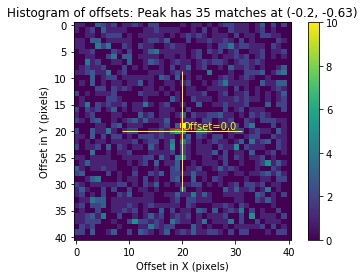

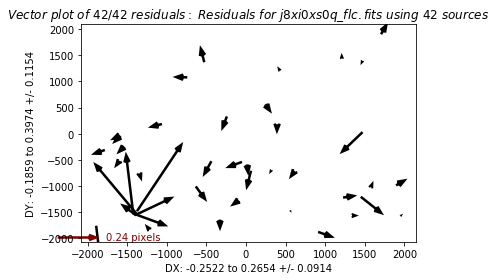

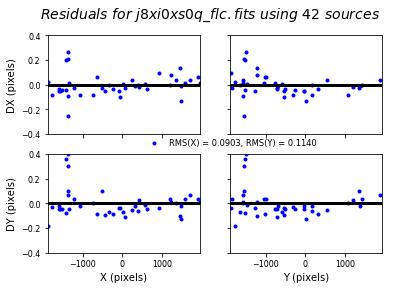

In [10]:
tweakreg.TweakReg('@input_flc.list',
                  imagefindcfg={'threshold': 100, 'conv_width': 6.0},
                  shiftfile=True, outshifts='shift814_flc_test2.txt',
                  updatehdr=False, interactive=False, ylimit=0.4)

In [11]:
# Give the 'fit residual plots' a unique name for comparison with subsequent tests.
residual_pngs = glob.glob("residual*png")
for png in residual_pngs: 
    path = os.path.abspath(os.path.join(os.curdir, png))
    new_path = os.path.abspath(os.path.join(os.curdir, 'test2_{}'.format(png)))
    os.rename(path, new_path)


TweakReg now finds matches ~50 objects per frame, and the fit for the first matched image `j8xi0xs0q_flc.fits` looks good, with an RMS ~0.1 pixels and with the residuals dx,dy clustered around 0.0.  For the other two frames `j8xi0xs3q_flc.fits` and `j8xi0xs6q_flc.fits`, the RMS is ~0.2 pixels, and the points are not centered around dx,dy=0 pixels.

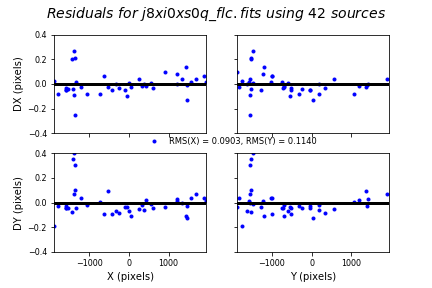

In [12]:
Image(filename='test2_residuals_j8xi0xs0q_flc.png')

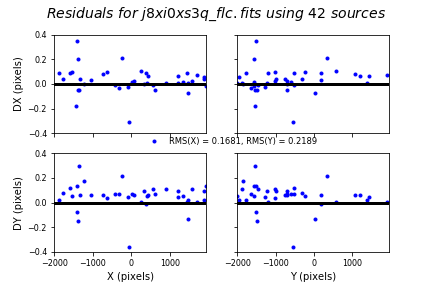

In [13]:
Image(filename='test2_residuals_j8xi0xs3q_flc.png')

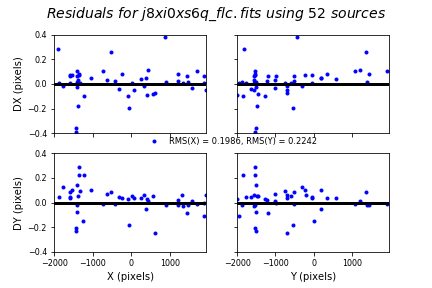

In [14]:
Image(filename='test2_residuals_j8xi0xs6q_flc.png')

In [15]:
# Inspect the shift file for Test2
shift_table = Table.read('shift814_flc_test2.txt', format='ascii.no_header', 
                       names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]
shift_table

<Table length=4>
       file           dx      dy     rot    scale    xrms    yrms 
      str18        float64 float64 float64 float64 float64 float64
------------------ ------- ------- ------- ------- ------- -------
j8xi0xsaq_flc.fits    0.00    0.00   0.000 1.00000    0.00    0.00
j8xi0xs6q_flc.fits    0.00   -0.03 359.998 1.00001    0.20    0.22
j8xi0xs3q_flc.fits   -0.04   -0.15 359.999 1.00001    0.17    0.22
j8xi0xs0q_flc.fits    0.07   -0.10   0.001 0.99998    0.09    0.11

## 3c. Exclude flagged pixels with `dqbits` (Test 3)

To further improve the alignment, we make use of flags in the DQ array of the FLC files. The source finding parameters in TweakReg may be modified to exclude flagged pixels when generating lists of objects in each image.

Setting the parameter `dqbits=0` will consider all non-zero pixels in the DQ mask to be “bad” pixels, and the corresponding image pixels will not be used for source finding. The default value of 'None' will turn off the use of image’s DQ array for source finding. In this case, AstroDrizzle was already run by MAST on visit 0X, and cosmic-ray flags were populated in the DQ array of the FLC frames. Since the exposures within this visit were already well aligned, the 4096 flags for cosmic rays are useful for excluding false detections.

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 15:12:59.072 (10/05/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 15:12:59.072 (10/05/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 7.3.0]


Python Version [GCC 7.3.0]


INFO:drizzlepac.util:3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


INFO:drizzlepac.util:numpy Version -> 1.15.4 


numpy Version -> 1.15.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.4.2 


stwcs Version -> 1.4.2 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	exclusions :	


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	input :	@input_flc.list


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakutils:j8xi0xsaq_flc.fits   


j8xi0xsaq_flc.fits   


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    j8xi0xsaq_flc.fits


    j8xi0xsaq_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs6q_flc.fits


    j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs3q_flc.fits


    j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs0q_flc.fits


    j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	6.0


INFO:drizzlepac.tweakreg:	dqbits :	0


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	@input_flc.list


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	100


INFO:drizzlepac.tweakreg:	updatehdr :	False


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.tweakreg:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xsaq_flc.fits':


===  Source finding for image 'j8xi0xsaq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 15:12:59.280 (10/05/2019)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 15:12:59.280 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.082394


INFO:drizzlepac.catalogs:###Source finding finished at: 15:13:00.264 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 1087 objects.


     Found 1087 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 15:13:00.364 (10/05/2019)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 15:13:00.364 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.901318


INFO:drizzlepac.catalogs:###Source finding finished at: 15:13:01.360 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 954 objects.


     Found 954 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 2041


===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 2041


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs6q_flc.fits':


===  Source finding for image 'j8xi0xs6q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 15:13:01.62 (10/05/2019)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 15:13:01.62 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.081750


INFO:drizzlepac.catalogs:###Source finding finished at: 15:13:02.56 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 755 objects.


     Found 755 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 15:13:02.660 (10/05/2019)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 15:13:02.660 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.046386


INFO:drizzlepac.catalogs:###Source finding finished at: 15:13:03.629 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 704 objects.


     Found 704 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 1459


===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 1459


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs3q_flc.fits':


===  Source finding for image 'j8xi0xs3q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 15:13:03.888 (10/05/2019)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 15:13:03.888 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.116258


INFO:drizzlepac.catalogs:###Source finding finished at: 15:13:04.85 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 628 objects.


     Found 628 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 15:13:04.946 (10/05/2019)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 15:13:04.946 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.016353


INFO:drizzlepac.catalogs:###Source finding finished at: 15:13:05.809 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 539 objects.


     Found 539 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 1167


===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 1167


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs0q_flc.fits':


===  Source finding for image 'j8xi0xs0q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 15:13:06.12 (10/05/2019)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 15:13:06.12 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.574701


INFO:drizzlepac.catalogs:###Source finding finished at: 15:13:07.032 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 618 objects.


     Found 618 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 15:13:07.128 (10/05/2019)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 15:13:07.128 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.441343


INFO:drizzlepac.catalogs:###Source finding finished at: 15:13:08.02 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 605 objects.


     Found 605 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 1223


===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 1223


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "j8xi0xsaq_flc.fits" to X,Y positions in reference WCS...


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'j8xi0xsaq_flc.fits'


derived from 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	searchrad :	1.0


INFO:drizzlepac.tweakreg:	searchunits :	arcseconds


INFO:drizzlepac.tweakreg:	see2dplot :	True


INFO:drizzlepac.tweakreg:	separation :	0.5


INFO:drizzlepac.tweakreg:	tolerance :	1.0


INFO:drizzlepac.tweakreg:	use2dhist :	True


INFO:drizzlepac.tweakreg:	xoffset :	0.0


INFO:drizzlepac.tweakreg:	yoffset :	0.0


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:


INFO:drizzlepac.tweakreg:	fitgeometry :	rscale


INFO:drizzlepac.tweakreg:	labelsize :	8


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	nclip :	3


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	sigma :	3.0


INFO:drizzlepac.tweakreg:	ylimit :	0.4


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:


INFO:drizzlepac.tweakreg:	outshifts :	shift814_flc_test3.txt


INFO:drizzlepac.tweakreg:	outwcs :	shifts_wcs.fits


INFO:drizzlepac.tweakreg:	shiftfile :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs6q_flc.fits


Performing fit for: j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.22222222222222143 -0.6984126984126995


Found initial X and Y shifts of  -0.22222222222222143 -0.6984126984126995


INFO:drizzlepac.tweakutils:    with significance of  362.78492695508515 and  19.0  matches


    with significance of  362.78492695508515 and  19.0  matches


INFO:drizzlepac.imgclasses:Found 50 matches for j8xi0xs6q_flc.fits...


Found 50 matches for j8xi0xs6q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0402  YSH: -0.0028    ROT: 359.9997955    SCALE: 1.000002


XSH: 0.0402  YSH: -0.0028    ROT: 359.9997955    SCALE: 1.000002


INFO:drizzlepac.imgclasses:XRMS: 0.055    YRMS: 0.064


XRMS: 0.055    YRMS: 0.064


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1e-06 (deg)   RMS_DEC: 6e-07 (deg)


RMS_RA: 1e-06 (deg)   RMS_DEC: 6e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  42  objects.


Final solution based on  42  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs6q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  42


Total # points:  42


INFO:drizzlepac.tweakutils:# of points after clipping:  42


# of points after clipping:  42


INFO:drizzlepac.tweakutils:Total # points:  42


Total # points:  42


INFO:drizzlepac.tweakutils:# of points after clipping:  42


# of points after clipping:  42


INFO:drizzlepac.updatehdr:....Updating header for j8xi0xs6q_flc.fits...


INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',2]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[4]


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs3q_flc.fits


Performing fit for: j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.5666666666666664 -0.8333333333333321


Found initial X and Y shifts of  -0.5666666666666664 -0.8333333333333321


INFO:drizzlepac.tweakutils:    with significance of  372.367064560268 and  21.0  matches


    with significance of  372.367064560268 and  21.0  matches


INFO:drizzlepac.imgclasses:Found 47 matches for j8xi0xs3q_flc.fits...


Found 47 matches for j8xi0xs3q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0066  YSH: -0.1050    ROT: 359.9996855    SCALE: 0.999997


XSH: 0.0066  YSH: -0.1050    ROT: 359.9996855    SCALE: 0.999997


INFO:drizzlepac.imgclasses:XRMS: 0.071    YRMS: 0.079


XRMS: 0.071    YRMS: 0.079


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.3e-06 (deg)   RMS_DEC: 7.7e-07 (deg)


RMS_RA: 1.3e-06 (deg)   RMS_DEC: 7.7e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  38  objects.


Final solution based on  38  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs3q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  38


Total # points:  38


INFO:drizzlepac.tweakutils:# of points after clipping:  38


# of points after clipping:  38


INFO:drizzlepac.tweakutils:Total # points:  38


Total # points:  38


INFO:drizzlepac.tweakutils:# of points after clipping:  38


# of points after clipping:  38


INFO:drizzlepac.updatehdr:....Updating header for j8xi0xs3q_flc.fits...


INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',1]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',2]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[4]


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs0q_flc.fits


Performing fit for: j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.0967741935483879 -0.758064516129032


Found initial X and Y shifts of  -0.0967741935483879 -0.758064516129032


INFO:drizzlepac.tweakutils:    with significance of  504.66094228369474 and  35.0  matches


    with significance of  504.66094228369474 and  35.0  matches


INFO:drizzlepac.imgclasses:Found 49 matches for j8xi0xs0q_flc.fits...


Found 49 matches for j8xi0xs0q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0596  YSH: -0.1223    ROT: 0.000347438054    SCALE: 0.999992


XSH: 0.0596  YSH: -0.1223    ROT: 0.000347438054    SCALE: 0.999992


INFO:drizzlepac.imgclasses:XRMS: 0.078    YRMS: 0.08


XRMS: 0.078    YRMS: 0.08


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.3e-06 (deg)   RMS_DEC: 8.8e-07 (deg)


RMS_RA: 1.3e-06 (deg)   RMS_DEC: 8.8e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  40  objects.


Final solution based on  40  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs0q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  40


Total # points:  40


INFO:drizzlepac.tweakutils:# of points after clipping:  40


# of points after clipping:  40


INFO:drizzlepac.tweakutils:Total # points:  40


Total # points:  40


INFO:drizzlepac.tweakutils:# of points after clipping:  40


# of points after clipping:  40


INFO:drizzlepac.updatehdr:....Updating header for j8xi0xs0q_flc.fits...


INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',1]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',2]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[4]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.tweakutils:Writing out shiftfile : shift814_flc_test3.txt


Writing out shiftfile : shift814_flc_test3.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


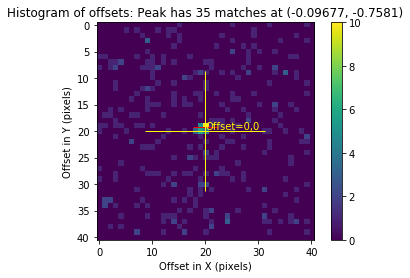

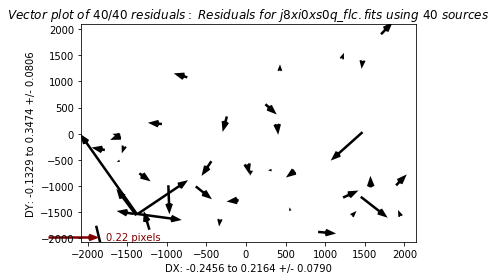

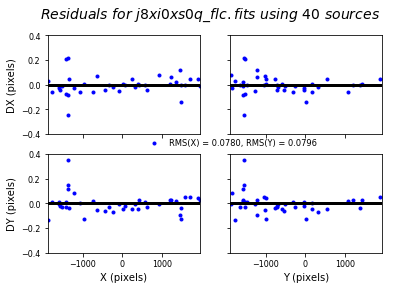

In [16]:
tweakreg.TweakReg('@input_flc.list',
                  imagefindcfg={'threshold': 100, 'conv_width': 6.0, 'dqbits': 0},
                  shiftfile=True, outshifts='shift814_flc_test3.txt',
                  updatehdr=False, interactive=False, ylimit=0.4)

In [17]:
# Give the 'fit residual plots' a unique name for comparison with other tests.
residual_pngs = glob.glob("residual*png")
for png in residual_pngs: 
    path = os.path.abspath(os.path.join(os.curdir, png))
    new_path = os.path.abspath(os.path.join(os.curdir, 'test3_{}'.format(png)))
    os.rename(path, new_path)   

In this third test, TweakReg again finds ~40 matches per frame, but with spurious detections eliminated has an easier time locking onto the correct solution.  The fit residuals below all have an RMS ~0.1 pixels and the points are all clustered around dx,dy=0.

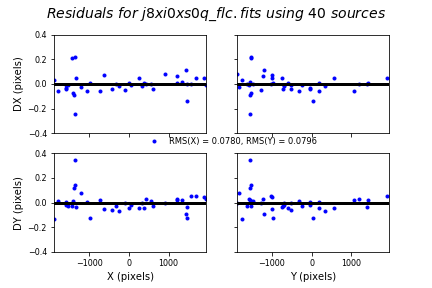

In [18]:
Image(filename='test3_residuals_j8xi0xs0q_flc.png')

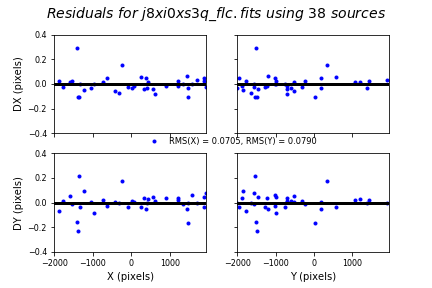

In [19]:
Image(filename='test3_residuals_j8xi0xs3q_flc.png')

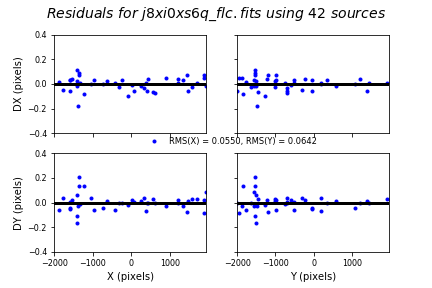

In [20]:
Image(filename='test3_residuals_j8xi0xs6q_flc.png')

In [21]:
# Inspect the shift file for Test2
shift_table = Table.read('shift814_flc_test3.txt', format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]
shift_table

<Table length=4>
       file           dx      dy     rot    scale    xrms    yrms 
      str18        float64 float64 float64 float64 float64 float64
------------------ ------- ------- ------- ------- ------- -------
j8xi0xsaq_flc.fits    0.00    0.00   0.000 1.00000    0.00    0.00
j8xi0xs6q_flc.fits    0.04   -0.00 360.000 1.00000    0.06    0.06
j8xi0xs3q_flc.fits    0.01   -0.11 360.000 1.00000    0.07    0.08
j8xi0xs0q_flc.fits    0.06   -0.12   0.000 0.99999    0.08    0.08

## 3d. Rerun TweakReg to update the header WCS

Now run TweakReg with `updatehdr=True` to update the image headers with this solution.

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 15:13:10. (10/05/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 15:13:10. (10/05/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 7.3.0]


Python Version [GCC 7.3.0]


INFO:drizzlepac.util:3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


INFO:drizzlepac.util:numpy Version -> 1.15.4 


numpy Version -> 1.15.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.4.2 


stwcs Version -> 1.4.2 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	exclusions :	


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	input :	@input_flc.list


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakutils:j8xi0xsaq_flc.fits   


j8xi0xsaq_flc.fits   


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    j8xi0xsaq_flc.fits


    j8xi0xsaq_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs6q_flc.fits


    j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs3q_flc.fits


    j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs0q_flc.fits


    j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	6.0


INFO:drizzlepac.tweakreg:	dqbits :	0


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	@input_flc.list


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	100


INFO:drizzlepac.tweakreg:	updatehdr :	True


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.tweakreg:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xsaq_flc.fits':


===  Source finding for image 'j8xi0xsaq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 15:13:11.242 (10/05/2019)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 15:13:11.242 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.082394


INFO:drizzlepac.catalogs:###Source finding finished at: 15:13:12.196 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 1087 objects.


     Found 1087 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 15:13:12.39 (10/05/2019)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 15:13:12.39 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.901318


INFO:drizzlepac.catalogs:###Source finding finished at: 15:13:13.32 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 954 objects.


     Found 954 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 2041


===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 2041


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs6q_flc.fits':


===  Source finding for image 'j8xi0xs6q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 15:13:13.641 (10/05/2019)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 15:13:13.641 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.081750


INFO:drizzlepac.catalogs:###Source finding finished at: 15:13:14.620 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 755 objects.


     Found 755 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 15:13:14.71 (10/05/2019)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 15:13:14.71 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.046386


INFO:drizzlepac.catalogs:###Source finding finished at: 15:13:15.652 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 704 objects.


     Found 704 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 1459


===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 1459


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs3q_flc.fits':


===  Source finding for image 'j8xi0xs3q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 15:13:15.956 (10/05/2019)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 15:13:15.956 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.116258


INFO:drizzlepac.catalogs:###Source finding finished at: 15:13:16.908 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 628 objects.


     Found 628 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 15:13:17.004 (10/05/2019)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 15:13:17.004 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.016353


INFO:drizzlepac.catalogs:###Source finding finished at: 15:13:17.909 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 539 objects.


     Found 539 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 1167


===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 1167


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs0q_flc.fits':


===  Source finding for image 'j8xi0xs0q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 15:13:18.171 (10/05/2019)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 15:13:18.171 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.574701


INFO:drizzlepac.catalogs:###Source finding finished at: 15:13:19.091 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 618 objects.


     Found 618 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 15:13:19.191 (10/05/2019)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 15:13:19.191 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.441343


INFO:drizzlepac.catalogs:###Source finding finished at: 15:13:20.139 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 605 objects.


     Found 605 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 1223


===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 1223


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "j8xi0xsaq_flc.fits" to X,Y positions in reference WCS...


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'j8xi0xsaq_flc.fits'


derived from 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	searchrad :	1.0


INFO:drizzlepac.tweakreg:	searchunits :	arcseconds


INFO:drizzlepac.tweakreg:	see2dplot :	True


INFO:drizzlepac.tweakreg:	separation :	0.5


INFO:drizzlepac.tweakreg:	tolerance :	1.0


INFO:drizzlepac.tweakreg:	use2dhist :	True


INFO:drizzlepac.tweakreg:	xoffset :	0.0


INFO:drizzlepac.tweakreg:	yoffset :	0.0


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:


INFO:drizzlepac.tweakreg:	fitgeometry :	rscale


INFO:drizzlepac.tweakreg:	labelsize :	8


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	nclip :	3


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	sigma :	3.0


INFO:drizzlepac.tweakreg:	ylimit :	None


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs6q_flc.fits


Performing fit for: j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.22222222222222143 -0.6984126984126995


Found initial X and Y shifts of  -0.22222222222222143 -0.6984126984126995


INFO:drizzlepac.tweakutils:    with significance of  362.78492695508515 and  19.0  matches


    with significance of  362.78492695508515 and  19.0  matches


INFO:drizzlepac.imgclasses:Found 50 matches for j8xi0xs6q_flc.fits...


Found 50 matches for j8xi0xs6q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0402  YSH: -0.0028    ROT: 359.9997955    SCALE: 1.000002


XSH: 0.0402  YSH: -0.0028    ROT: 359.9997955    SCALE: 1.000002


INFO:drizzlepac.imgclasses:XRMS: 0.055    YRMS: 0.064


XRMS: 0.055    YRMS: 0.064


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1e-06 (deg)   RMS_DEC: 6e-07 (deg)


RMS_RA: 1e-06 (deg)   RMS_DEC: 6e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  42  objects.


Final solution based on  42  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs6q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  42


Total # points:  42


INFO:drizzlepac.tweakutils:# of points after clipping:  42


# of points after clipping:  42


INFO:drizzlepac.tweakutils:Total # points:  42


Total # points:  42


INFO:drizzlepac.tweakutils:# of points after clipping:  42


# of points after clipping:  42


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for j8xi0xs6q_flc.fits...


....Updating header for j8xi0xs6q_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',1]


Processing j8xi0xs6q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[1]


Updating header for j8xi0xs6q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.8100878099842194e-06 1.3844834699641343e-05


CD_11  CD_12: 2.8100878099842194e-06 1.3844834699641343e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3557441326549291e-05 -1.887790519389511e-06


CD_21  CD_22: 1.3557441326549291e-05 -1.887790519389511e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.18752974807956 2.678737131147837


CRVAL    : 150.18752974807956 2.678737131147837


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049844274512112006


Plate Scale : 0.049844274512112006


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.76459118154769


ORIENTAT : 97.76459118154769


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',2]


Processing j8xi0xs6q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[4]


Updating header for j8xi0xs6q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.9565875532241413e-06 1.3396511053676178e-05


CD_11  CD_12: 2.9565875532241413e-06 1.3396511053676178e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3360530741538096e-05 -1.7229788484596075e-06


CD_21  CD_22: 1.3360530741538096e-05 -1.7229788484596075e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.2161824835538 2.6748949510833047


CRVAL    : 150.2161824835538 2.6748949510833047


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04926161476778738


Plate Scale : 0.04926161476778738


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.32880604345358


ORIENTAT : 97.32880604345358


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs3q_flc.fits


Performing fit for: j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.5666666666666664 -0.8333333333333321


Found initial X and Y shifts of  -0.5666666666666664 -0.8333333333333321


INFO:drizzlepac.tweakutils:    with significance of  372.367064560268 and  21.0  matches


    with significance of  372.367064560268 and  21.0  matches


INFO:drizzlepac.imgclasses:Found 47 matches for j8xi0xs3q_flc.fits...


Found 47 matches for j8xi0xs3q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0066  YSH: -0.1050    ROT: 359.9996855    SCALE: 0.999997


XSH: 0.0066  YSH: -0.1050    ROT: 359.9996855    SCALE: 0.999997


INFO:drizzlepac.imgclasses:XRMS: 0.071    YRMS: 0.079


XRMS: 0.071    YRMS: 0.079


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.3e-06 (deg)   RMS_DEC: 7.7e-07 (deg)


RMS_RA: 1.3e-06 (deg)   RMS_DEC: 7.7e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  38  objects.


Final solution based on  38  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs3q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  38


Total # points:  38


INFO:drizzlepac.tweakutils:# of points after clipping:  38


# of points after clipping:  38


INFO:drizzlepac.tweakutils:Total # points:  38


Total # points:  38


INFO:drizzlepac.tweakutils:# of points after clipping:  38


# of points after clipping:  38


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for j8xi0xs3q_flc.fits...


....Updating header for j8xi0xs3q_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',1]


Processing j8xi0xs3q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[1]


Updating header for j8xi0xs3q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.8101287259314283e-06 1.3845167802532859e-05


CD_11  CD_12: 2.8101287259314283e-06 1.3845167802532859e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3557769372549166e-05 -1.8878089266267742e-06


CD_21  CD_22: 1.3557769372549166e-05 -1.8878089266267742e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.18835242022843 2.678524784866032


CRVAL    : 150.18835242022843 2.678524784866032


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04984521986664923


Plate Scale : 0.04984521986664923


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.76448143556931


ORIENTAT : 97.76448143556931


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',2]


Processing j8xi0xs3q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[4]


Updating header for j8xi0xs3q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.95663230027647e-06 1.3396833186838974e-05

CD_11  CD_12: 2.95663230027647e-06 1.3396833186838974e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3360854376532596e-05 -1.722994181142128e-06


CD_21  CD_22: 1.3360854376532596e-05 -1.722994181142128e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.21700584001897 2.6746825681922153


CRVAL    : 150.21700584001897 2.6746825681922153


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04926254902188699


Plate Scale : 0.04926254902188699


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.32869624273093


ORIENTAT : 97.32869624273093


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs0q_flc.fits


Performing fit for: j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.0967741935483879 -0.758064516129032


Found initial X and Y shifts of  -0.0967741935483879 -0.758064516129032


INFO:drizzlepac.tweakutils:    with significance of  504.66094228369474 and  35.0  matches


    with significance of  504.66094228369474 and  35.0  matches


INFO:drizzlepac.imgclasses:Found 49 matches for j8xi0xs0q_flc.fits...


Found 49 matches for j8xi0xs0q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0596  YSH: -0.1223    ROT: 0.000347438054    SCALE: 0.999992


XSH: 0.0596  YSH: -0.1223    ROT: 0.000347438054    SCALE: 0.999992


INFO:drizzlepac.imgclasses:XRMS: 0.078    YRMS: 0.08


XRMS: 0.078    YRMS: 0.08


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.3e-06 (deg)   RMS_DEC: 8.8e-07 (deg)


RMS_RA: 1.3e-06 (deg)   RMS_DEC: 8.8e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  40  objects.


Final solution based on  40  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs0q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  40


Total # points:  40


INFO:drizzlepac.tweakutils:# of points after clipping:  40


# of points after clipping:  40


INFO:drizzlepac.tweakutils:Total # points:  40


Total # points:  40


INFO:drizzlepac.tweakutils:# of points after clipping:  40


# of points after clipping:  40


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for j8xi0xs0q_flc.fits...


....Updating header for j8xi0xs0q_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',1]


Processing j8xi0xs0q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[1]


Updating header for j8xi0xs0q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.8103648807548032e-06 1.3845427354502308e-05


CD_11  CD_12: 2.8103648807548032e-06 1.3845427354502308e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3558010842738697e-05 -1.8880299294094418e-06


CD_21  CD_22: 1.3558010842738697e-05 -1.8880299294094418e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.18920940428802 2.6784806717108833


CRVAL    : 150.18920940428802 2.6784806717108833


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04984597991229051


Plate Scale : 0.04984597991229051


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.76523552446345


ORIENTAT : 97.76523552446345


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',2]


Processing j8xi0xs0q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[4]


Updating header for j8xi0xs0q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.9568688572743883e-06 1.3397085675083097e-05


CD_11  CD_12: 2.9568688572743883e-06 1.3397085675083097e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3361089899612285e-05 -1.723205877279661e-06


CD_21  CD_22: 1.3361089899612285e-05 -1.723205877279661e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.21786336095803 2.6746379994347484


CRVAL    : 150.21786336095803 2.6746379994347484


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049263300242822126


Plate Scale : 0.049263300242822126


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.3294502588655


ORIENTAT : 97.3294502588655


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.imgclasses:    Saving Primary WCS to alternate WCS: " "


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


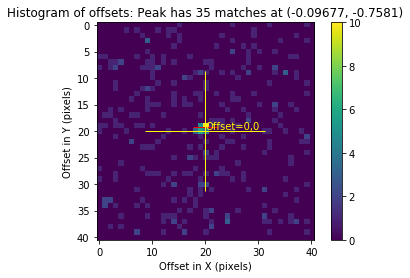

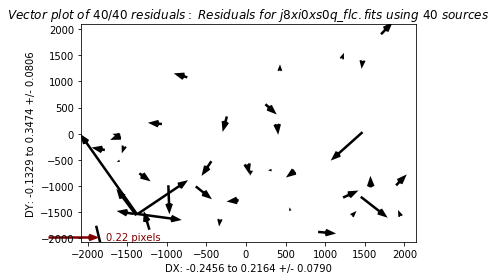

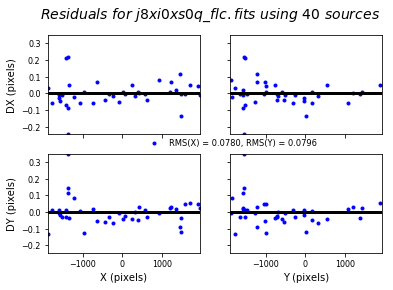

In [22]:
tweakreg.TweakReg('@input_flc.list',
                  imagefindcfg={'threshold': 100, 'conv_width': 6.0, 'dqbits': 0},
                  shiftfile=False, updatehdr=True, interactive=False)

# 4. Drizzle the aligned frames

Combine the aligned FLC files with AstroDrizzle. The ACS team now corrects for stable hot pixels (DQ flag=16) via the dark reference files, so these pixels can be considered 'good'. Full well saturated pixels (DQ flag=256) and warm pixels (DQ flag=64) may also be treated as good. More details on the recommended drizzle parameters for ACS may be found in [ISR 2017-02](http://www.stsci.edu/hst/acs/documents/isrs/isr1702.pdf).

In [23]:
astrodrizzle.AstroDrizzle('*flc.fits',
                          output='f814w',
                          preserve=False,
                          clean=True,
                          build=False,
                          context=False,
                          driz_sep_bits='256,64,16',
                          combine_type='median',
                          final_bits='256,64,16',
                          runfile='f814w_driz.log')

INFO:drizzlepac.util:Setting up logfile :  f814w_driz.log


Setting up logfile :  f814w_driz.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 15:13:25.328 (10/05/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 15:13:25.328 (10/05/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version [GCC 7.3.0]


INFO:drizzlepac.astrodrizzle:3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.15.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.2 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.2 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  15:13:25.332 (10/05/2019)


==== Processing Step  Initialization  started at  15:13:25.332 (10/05/2019)


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: f814w_drc.fits


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 55.52809143066406


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 55.52809143066406


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 50.70233535766601


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 50.70233535766601


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 50.87463760375977


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 50.87463760375977


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 50.27589797973633


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 50.27589797973633


INFO:drizzlepac.imageObject:No context image will be created for j8xi0xs0q_flc.fits


INFO:drizzlepac.imageObject:No context image will be created for j8xi0xs3q_flc.fits


INFO:drizzlepac.imageObject:No context image will be created for j8xi0xs6q_flc.fits


INFO:drizzlepac.imageObject:No context image will be created for j8xi0xsaq_flc.fits


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in j8xi0xs0q_flc.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in j8xi0xs0q_flc.fits[DQ,2]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in j8xi0xs3q_flc.fits[DQ,1]

INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in j8xi0xs3q_flc.fits[DQ,2]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in j8xi0xs6q_flc.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in j8xi0xs6q_flc.fits[DQ,2]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in j8xi0xsaq_flc.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in j8xi0xsaq_flc.fits[DQ,2]


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:drizzlepac.imageObject:No context image will be created for f814w_drc.fits


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 150.20217288741807  2.6769438230145677  


CRVAL : 150.20217288741807  2.6769438230145677  


INFO:astropy.wcs.wcs:CRPIX : 2111.0  2210.5  


CRPIX : 2111.0  2210.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 2.4116113795014276e-06  1.3677915233037544e-05  


CD1_1 CD1_2  : 2.4116113795014276e-06  1.3677915233037544e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 1.3677915233037544e-05  -2.4116113795014276e-06  


CD2_1 CD2_2  : 1.3677915233037544e-05  -2.4116113795014276e-06  


INFO:astropy.wcs.wcs:NAXIS : 4222  4421


NAXIS : 4222  4421


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 2220 Mb.


*  Estimated memory usage:  up to 2220 Mb.


INFO:drizzlepac.processInput:*  Output image size:       4222 X 4421 pixels. 


*  Output image size:       4222 X 4421 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 213 Mb. 


*  Output image file:       ~ 213 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         8


*  Cores available:         8


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  15:13:27.631 (10/05/2019)


==== Processing Step  Initialization  finished at  15:13:27.631 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	False


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	False


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	*flc.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	False


INFO:drizzlepac.astrodrizzle:	num_cores :	None


INFO:drizzlepac.astrodrizzle:	output :	f814w


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	4096


INFO:drizzlepac.astrodrizzle:	runfile :	f814w_driz.log


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  15:13:27.645 (10/05/2019)


==== Processing Step  Static Mask  started at  15:13:27.645 (10/05/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 55.075737;   rms = 10.970817;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 54.523428;   rms = 9.846490;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 50.450047;   rms = 10.694613;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 49.525925;   rms = 9.588069;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 51.066159;   rms = 10.823057;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 50.308009;   rms = 9.621310;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 50.493014;   rms = 11.489667;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 49.916463;   rms = 9.758092;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./ACSWFC_2048x4096_1_staticMask.fits


INFO:drizzlepac.staticMask:Saving static mask to disk: ./ACSWFC_2048x4096_2_staticMask.fits


INFO:drizzlepac.util:==== Processing Step  Static Mask  finished at  15:13:30.342 (10/05/2019)


==== Processing Step  Static Mask  finished at  15:13:30.342 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  15:13:30.345 (10/05/2019)


==== Processing Step  Subtract Sky  started at  15:13:30.345 (10/05/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	0


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	


INFO:drizzlepac.sky:	skylower :	None


INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	


INFO:drizzlepac.sky:	skymethod :	localmin


INFO:drizzlepac.sky:	skystat :	median


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	


INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.1


INFO:drizzlepac.sky:	use_static :	True


INFO:stsci.skypac.utils:***** skymatch started on 2019-05-10 15:13:31.220991


***** skymatch started on 2019-05-10 15:13:31.220991


INFO:stsci.skypac.utils:      Version 1.0.2 (2019-03-07 00:54:44 -0500)


      Version 1.0.2 (2019-03-07 00:54:44 -0500)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'j8xi0xs0q_flc.fits'


   **  Input image: 'j8xi0xs0q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: j8xi0xs0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: j8xi0xs0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: j8xi0xs0q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: j8xi0xs0q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'j8xi0xs3q_flc.fits'


   **  Input image: 'j8xi0xs3q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: j8xi0xs3q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: j8xi0xs3q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: j8xi0xs3q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: j8xi0xs3q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'j8xi0xs6q_flc.fits'


   **  Input image: 'j8xi0xs6q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: j8xi0xs6q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: j8xi0xs6q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: j8xi0xs6q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: j8xi0xs6q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'j8xi0xsaq_flc.fits'


   **  Input image: 'j8xi0xsaq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: j8xi0xsaq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: j8xi0xsaq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: j8xi0xsaq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: j8xi0xsaq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: j8xi0xs0q_flc.fits


   *   Image: j8xi0xs0q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]

             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: j8xi0xs3q_flc.fits


   *   Image: j8xi0xs3q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: j8xi0xs6q_flc.fits


   *   Image: j8xi0xs6q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: j8xi0xsaq_flc.fits


   *   Image: j8xi0xsaq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing sky values requested image extensions (detector chips):  -----


-----  Computing sky values requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image:   'j8xi0xs0q_flc.fits['SCI',1,2]'  --  SKY = 43.80914511294995 (brightness units)


   *   Image:   'j8xi0xs0q_flc.fits['SCI',1,2]'  --  SKY = 43.80914511294995 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 55.5281   NEW MDRIZSKY = 55.5281


      - EXT = 'SCI',1   delta(MDRIZSKY) = 55.5281   NEW MDRIZSKY = 55.5281


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 55.5281   NEW MDRIZSKY = 55.5281


      - EXT = 'SCI',2   delta(MDRIZSKY) = 55.5281   NEW MDRIZSKY = 55.5281


INFO:stsci.skypac.utils:   *   Image:   'j8xi0xs3q_flc.fits['SCI',1,2]'  --  SKY = 40.00184249125523 (brightness units)


   *   Image:   'j8xi0xs3q_flc.fits['SCI',1,2]'  --  SKY = 40.00184249125523 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.7023   NEW MDRIZSKY = 50.7023


      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.7023   NEW MDRIZSKY = 50.7023


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.7023   NEW MDRIZSKY = 50.7023


      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.7023   NEW MDRIZSKY = 50.7023


INFO:stsci.skypac.utils:   *   Image:   'j8xi0xs6q_flc.fits['SCI',1,2]'  --  SKY = 40.1377811469505 (brightness units)


   *   Image:   'j8xi0xs6q_flc.fits['SCI',1,2]'  --  SKY = 40.1377811469505 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.8746   NEW MDRIZSKY = 50.8746


      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.8746   NEW MDRIZSKY = 50.8746


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.8746   NEW MDRIZSKY = 50.8746


      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.8746   NEW MDRIZSKY = 50.8746


INFO:stsci.skypac.utils:   *   Image:   'j8xi0xsaq_flc.fits['SCI',1,2]'  --  SKY = 39.6654027453541 (brightness units)


   *   Image:   'j8xi0xsaq_flc.fits['SCI',1,2]'  --  SKY = 39.6654027453541 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.2759   NEW MDRIZSKY = 50.2759


      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.2759   NEW MDRIZSKY = 50.2759


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.2759   NEW MDRIZSKY = 50.2759


      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.2759   NEW MDRIZSKY = 50.2759


INFO:stsci.skypac.utils:***** skymatch ended on 2019-05-10 15:13:35.385012


***** skymatch ended on 2019-05-10 15:13:35.385012


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:04.164021


TOTAL RUN TIME: 0:00:04.164021


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  15:13:35.678 (10/05/2019)


==== Processing Step  Subtract Sky  finished at  15:13:35.678 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  15:13:35.681 (10/05/2019)


==== Processing Step  Separate Drizzle  started at  15:13:35.681 (10/05/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 336, 'compress': False, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	336


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	True


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	compress :	False


INFO:drizzlepac.adrizzle:	crbit :	None


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	turbo


INFO:drizzlepac.adrizzle:	num_cores :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	electrons


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	None


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel turbo


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 150.20217288741807  2.6769438230145677  


CRVAL : 150.20217288741807  2.6769438230145677  


INFO:astropy.wcs.wcs:CRPIX : 2111.0  2210.5  


CRPIX : 2111.0  2210.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 2.4116113795014276e-06  1.3677915233037544e-05  


CD1_1 CD1_2  : 2.4116113795014276e-06  1.3677915233037544e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 1.3677915233037544e-05  -2.4116113795014276e-06  


CD2_1 CD2_2  : 1.3677915233037544e-05  -2.4116113795014276e-06  


INFO:astropy.wcs.wcs:NAXIS : 4222  4421


NAXIS : 4222  4421


INFO:drizzlepac.adrizzle:Executing 4 parallel workers


INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs3q_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs6q_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xsaq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 50.702335 to j8xi0xs3q_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 50.874638 to j8xi0xs6q_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 50.275898 to j8xi0xsaq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs0q_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 55.528091 to j8xi0xs0q_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo


INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs3q_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs6q_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 50.702335 to j8xi0xs3q_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 50.874638 to j8xi0xs6q_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xsaq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs0q_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 50.275898 to j8xi0xsaq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 55.528091 to j8xi0xs0q_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo


INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs3q_single_sci.fits


-Generating simple FITS output: j8xi0xs3q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs3q_single_sci.fits


Writing out image to disk: j8xi0xs3q_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs6q_single_sci.fits


-Generating simple FITS output: j8xi0xs6q_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xsaq_single_sci.fits


-Generating simple FITS output: j8xi0xsaq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs6q_single_sci.fits


Writing out image to disk: j8xi0xs6q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xsaq_single_sci.fits


Writing out image to disk: j8xi0xsaq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs0q_single_sci.fits


-Generating simple FITS output: j8xi0xs0q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs3q_single_wht.fits


Writing out image to disk: j8xi0xs3q_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs0q_single_sci.fits


Writing out image to disk: j8xi0xs0q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs6q_single_wht.fits


Writing out image to disk: j8xi0xs6q_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xsaq_single_wht.fits


Writing out image to disk: j8xi0xsaq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs0q_single_wht.fits


Writing out image to disk: j8xi0xs0q_single_wht.fits


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  15:13:40.450 (10/05/2019)


==== Processing Step  Separate Drizzle  finished at  15:13:40.450 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  15:13:40.453 (10/05/2019)


==== Processing Step  Create Median  started at  15:13:40.453 (10/05/2019)


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:


INFO:drizzlepac.createMedian:	combine_bufsize :	None


INFO:drizzlepac.createMedian:	combine_grow :	1


INFO:drizzlepac.createMedian:	combine_hthresh :	None


INFO:drizzlepac.createMedian:	combine_lthresh :	None


INFO:drizzlepac.createMedian:	combine_maskpt :	0.3


INFO:drizzlepac.createMedian:	combine_nhigh :	0


INFO:drizzlepac.createMedian:	combine_nlow :	0


INFO:drizzlepac.createMedian:	combine_nsigma :	4 3


INFO:drizzlepac.createMedian:	combine_type :	median


INFO:drizzlepac.createMedian:	compress :	False


INFO:drizzlepac.createMedian:	median :	True


INFO:drizzlepac.createMedian:	median_newmasks :	True


INFO:drizzlepac.createMedian:	proc_unit :	native


INFO:drizzlepac.createMedian:reference sky value for image 'j8xi0xs0q_flc.fits' is 55.52809143066406


reference sky value for image 'j8xi0xs0q_flc.fits' is 55.52809143066406


INFO:drizzlepac.createMedian:reference sky value for image 'j8xi0xs3q_flc.fits' is 50.70233535766601


reference sky value for image 'j8xi0xs3q_flc.fits' is 50.70233535766601


INFO:drizzlepac.createMedian:reference sky value for image 'j8xi0xs6q_flc.fits' is 50.874637603759766


reference sky value for image 'j8xi0xs6q_flc.fits' is 50.874637603759766


INFO:drizzlepac.createMedian:reference sky value for image 'j8xi0xsaq_flc.fits' is 50.27589797973633


reference sky value for image 'j8xi0xsaq_flc.fits' is 50.27589797973633


INFO:drizzlepac.createMedian:Saving output median image to: 'f814w_med.fits'


Saving output median image to: 'f814w_med.fits'


INFO:drizzlepac.util:==== Processing Step  Create Median  finished at  15:13:45.188 (10/05/2019)


==== Processing Step  Create Median  finished at  15:13:45.188 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Blot  started at  15:13:45.191 (10/05/2019)


==== Processing Step  Blot  started at  15:13:45.191 (10/05/2019)


INFO:drizzlepac.ablot:USER INPUT PARAMETERS for Blot Step:


INFO:drizzlepac.ablot:	blot_addsky :	True


INFO:drizzlepac.ablot:	blot_interp :	poly5


INFO:drizzlepac.ablot:	blot_sinscl :	1.0


INFO:drizzlepac.ablot:	blot_skyval :	0.0


INFO:drizzlepac.ablot:	coeffs :	True


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xs0q_flc.fits[sci,1]


    Blot: creating blotted image:  j8xi0xs0q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 55.528091 to blotted image j8xi0xs0q_flc.fits[sci,1]


INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs0q_sci1_blt.fits


-Generating simple FITS output: j8xi0xs0q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs0q_sci1_blt.fits


Writing out image to disk: j8xi0xs0q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xs0q_flc.fits[sci,2]


    Blot: creating blotted image:  j8xi0xs0q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 55.528091 to blotted image j8xi0xs0q_flc.fits[sci,2]


INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs0q_sci2_blt.fits


-Generating simple FITS output: j8xi0xs0q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs0q_sci2_blt.fits


Writing out image to disk: j8xi0xs0q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xs3q_flc.fits[sci,1]


    Blot: creating blotted image:  j8xi0xs3q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.702335 to blotted image j8xi0xs3q_flc.fits[sci,1]


INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs3q_sci1_blt.fits


-Generating simple FITS output: j8xi0xs3q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs3q_sci1_blt.fits


Writing out image to disk: j8xi0xs3q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xs3q_flc.fits[sci,2]


    Blot: creating blotted image:  j8xi0xs3q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.702335 to blotted image j8xi0xs3q_flc.fits[sci,2]


INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs3q_sci2_blt.fits


-Generating simple FITS output: j8xi0xs3q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs3q_sci2_blt.fits


Writing out image to disk: j8xi0xs3q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xs6q_flc.fits[sci,1]


    Blot: creating blotted image:  j8xi0xs6q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.874638 to blotted image j8xi0xs6q_flc.fits[sci,1]


INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs6q_sci1_blt.fits


-Generating simple FITS output: j8xi0xs6q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs6q_sci1_blt.fits


Writing out image to disk: j8xi0xs6q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xs6q_flc.fits[sci,2]


    Blot: creating blotted image:  j8xi0xs6q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.874638 to blotted image j8xi0xs6q_flc.fits[sci,2]


INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs6q_sci2_blt.fits


-Generating simple FITS output: j8xi0xs6q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs6q_sci2_blt.fits


Writing out image to disk: j8xi0xs6q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xsaq_flc.fits[sci,1]


    Blot: creating blotted image:  j8xi0xsaq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.275898 to blotted image j8xi0xsaq_flc.fits[sci,1]


INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xsaq_sci1_blt.fits


-Generating simple FITS output: j8xi0xsaq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xsaq_sci1_blt.fits


Writing out image to disk: j8xi0xsaq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xsaq_flc.fits[sci,2]


    Blot: creating blotted image:  j8xi0xsaq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.275898 to blotted image j8xi0xsaq_flc.fits[sci,2]


INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xsaq_sci2_blt.fits


-Generating simple FITS output: j8xi0xsaq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xsaq_sci2_blt.fits


Writing out image to disk: j8xi0xsaq_sci2_blt.fits


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  15:13:59.164 (10/05/2019)


==== Processing Step  Blot  finished at  15:13:59.164 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  15:13:59.16 (10/05/2019)


==== Processing Step  Driz_CR  started at  15:13:59.16 (10/05/2019)


INFO:drizzlepac.drizCR:USER INPUT PARAMETERS for Driz_CR Step:


INFO:drizzlepac.drizCR:	crbit :	4096


INFO:drizzlepac.drizCR:	driz_cr :	True


INFO:drizzlepac.drizCR:	driz_cr_corr :	False


INFO:drizzlepac.drizCR:	driz_cr_ctegrow :	0


INFO:drizzlepac.drizCR:	driz_cr_grow :	1


INFO:drizzlepac.drizCR:	driz_cr_scale :	1.2 0.7


INFO:drizzlepac.drizCR:	driz_cr_snr :	3.5 3.0


INFO:drizzlepac.drizCR:	inmemory :	False


INFO:drizzlepac.drizCR:Executing 4 parallel workers


INFO:drizzlepac.drizCR:Creating output :  j8xi0xs0q_sci1_crmask.fits


Creating output :  j8xi0xs0q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  j8xi0xs3q_sci1_crmask.fits


Creating output :  j8xi0xs3q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  j8xi0xs6q_sci1_crmask.fits


Creating output :  j8xi0xs6q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  j8xi0xsaq_sci1_crmask.fits


Creating output :  j8xi0xsaq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  j8xi0xs3q_sci2_crmask.fits


Creating output :  j8xi0xs3q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  j8xi0xs0q_sci2_crmask.fits


Creating output :  j8xi0xs0q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  j8xi0xs6q_sci2_crmask.fits


Creating output :  j8xi0xs6q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  j8xi0xsaq_sci2_crmask.fits


Creating output :  j8xi0xsaq_sci2_crmask.fits


INFO:drizzlepac.util:==== Processing Step  Driz_CR  finished at  15:14:10.216 (10/05/2019)


==== Processing Step  Driz_CR  finished at  15:14:10.216 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  15:14:10.237 (10/05/2019)


==== Processing Step  Final Drizzle  started at  15:14:10.237 (10/05/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 336, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	336


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	True


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 150.20217288741807  2.6769438230145677  


CRVAL : 150.20217288741807  2.6769438230145677  


INFO:astropy.wcs.wcs:CRPIX : 2111.0  2210.5  


CRPIX : 2111.0  2210.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 2.4116113795014276e-06  1.3677915233037544e-05  


CD1_1 CD1_2  : 2.4116113795014276e-06  1.3677915233037544e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 1.3677915233037544e-05  -2.4116113795014276e-06  


CD2_1 CD2_2  : 1.3677915233037544e-05  -2.4116113795014276e-06  


INFO:astropy.wcs.wcs:NAXIS : 4222  4421


NAXIS : 4222  4421


INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs0q_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 55.528091 to j8xi0xs0q_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs0q_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 55.528091 to j8xi0xs0q_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs3q_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 50.702335 to j8xi0xs3q_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs3q_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 50.702335 to j8xi0xs3q_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs6q_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 50.874638 to j8xi0xs6q_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs6q_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 50.874638 to j8xi0xs6q_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xsaq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 50.275898 to j8xi0xsaq_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xsaq_flc.fits[sci,2]

INFO:drizzlepac.adrizzle:Applying sky value of 50.275898 to j8xi0xsaq_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating simple FITS output: f814w_drc_sci.fits


-Generating simple FITS output: f814w_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f814w_drc_sci.fits


Writing out image to disk: f814w_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f814w_drc_wht.fits


Writing out image to disk: f814w_drc_wht.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  15:14:38.394 (10/05/2019)


==== Processing Step  Final Drizzle  finished at  15:14:38.394 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 is finished processing at 15:14:38.398 (10/05/2019).


AstroDrizzle Version 2.2.6 is finished processing at 15:14:38.398 (10/05/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          2.2990 sec.


         Initialization          2.2990 sec.


INFO:drizzlepac.util:            Static Mask          2.6973 sec.


            Static Mask          2.6973 sec.


INFO:drizzlepac.util:           Subtract Sky          5.3330 sec.


           Subtract Sky          5.3330 sec.


INFO:drizzlepac.util:       Separate Drizzle          4.7694 sec.


       Separate Drizzle          4.7694 sec.


INFO:drizzlepac.util:          Create Median          4.7349 sec.


          Create Median          4.7349 sec.


INFO:drizzlepac.util:                   Blot          13.9724 sec.


                   Blot          13.9724 sec.


INFO:drizzlepac.util:                Driz_CR          11.0491 sec.


                Driz_CR          11.0491 sec.


INFO:drizzlepac.util:          Final Drizzle          28.1567 sec.


          Final Drizzle          28.1567 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          73.0119 sec.


                  Total          73.0119 sec.


INFO:drizzlepac.imageObject:Removing intermediate files for j8xi0xs0q_flc.fits


INFO:drizzlepac.imageObject:Removing intermediate files for j8xi0xs3q_flc.fits


INFO:drizzlepac.imageObject:Removing intermediate files for j8xi0xs6q_flc.fits


INFO:drizzlepac.imageObject:Removing intermediate files for j8xi0xsaq_flc.fits


INFO:drizzlepac.util:Trailer file written to:  f814w_driz.log


Trailer file written to:  f814w_driz.log


# 5. Display the original FLC image and the combined DRC data

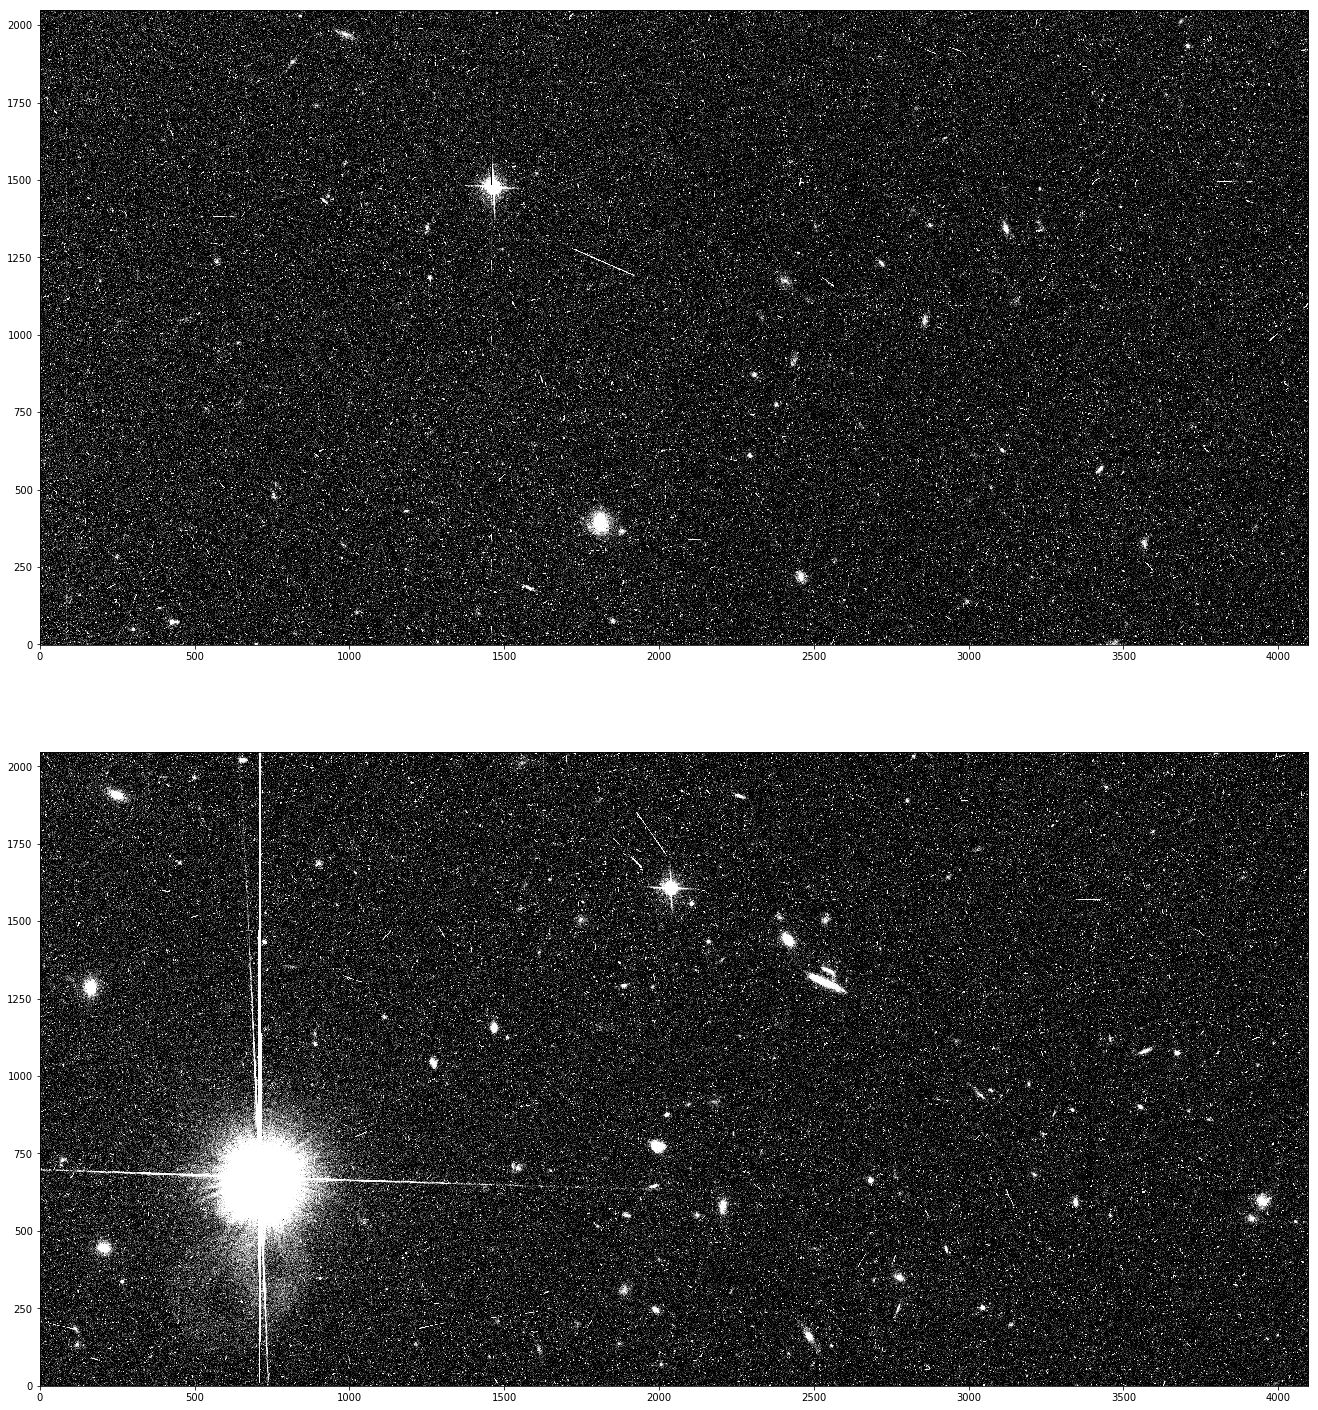

In [24]:
sci2 = fits.getdata('j8xi0xsaq_flc.fits', ('sci', 2))
sci1 = fits.getdata('j8xi0xsaq_flc.fits', ('sci', 1))

fig = plt.figure(figsize=(50, 50))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(1, 2, 1)

ax1.imshow(sci2, vmin=50, vmax=100, cmap='Greys_r', origin='lower')
ax2.imshow(sci1, vmin=50, vmax=100, cmap='Greys_r', origin='lower')

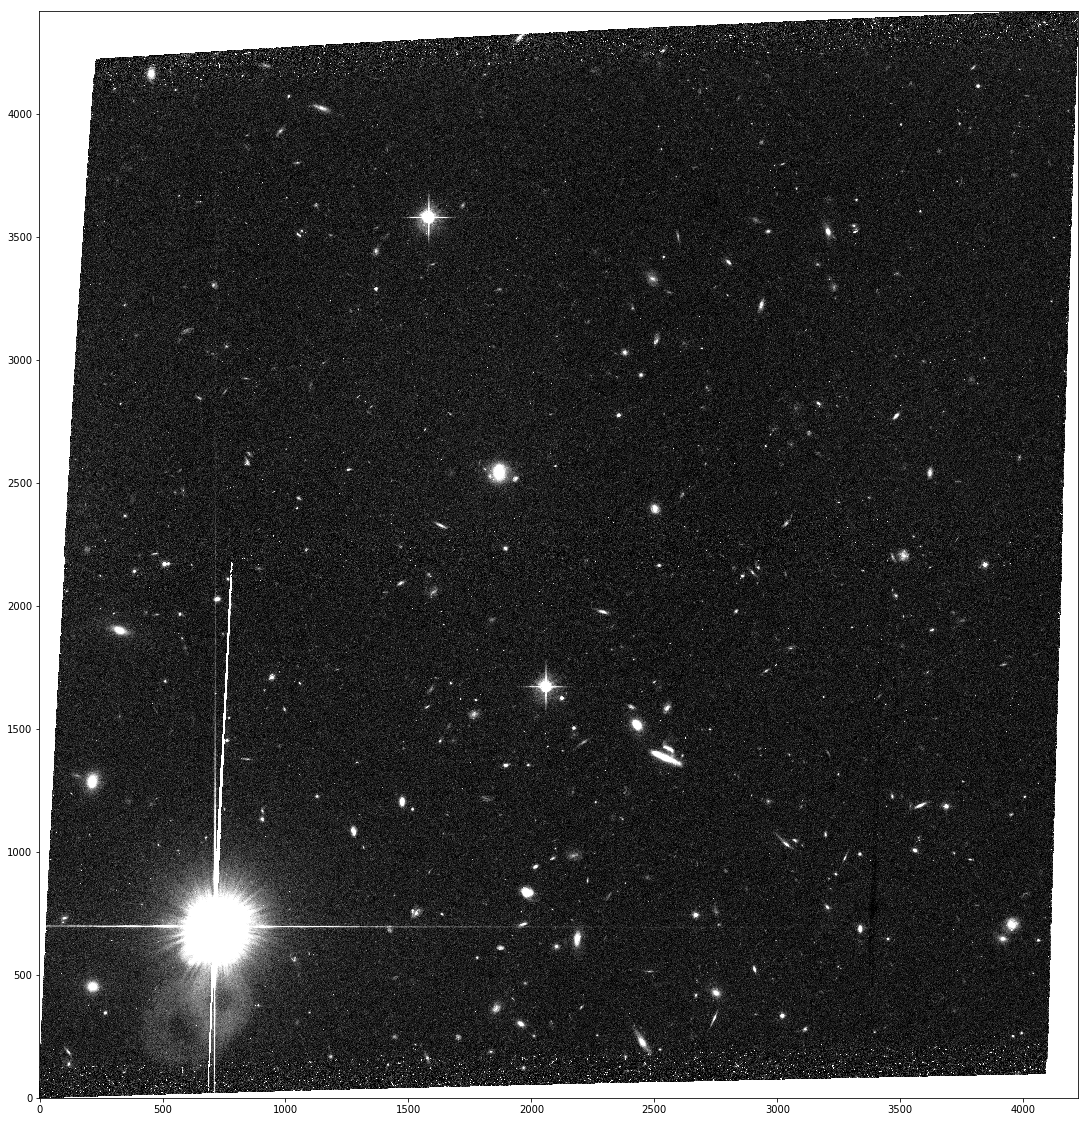

In [25]:
sci = fits.getdata('f814w_drc_sci.fits')
fig = plt.figure(figsize=(20, 20))
plt.imshow(sci, vmin=-0.01, vmax=0.1, cmap='Greys_r', origin='lower')

# Summary

TweakReg may be used to align HST images based on the position of objects in the frame. Point sources are typically used for this purpose, but compact sources such as background galaxies may also be used by increasing the value of the parameter `conv_width` in `imagefindpars`. The data quality arrays of the input calibrated frames may also be used to further improve the fits by telling TweakReg to ignore pixels with specific flags inthe DQ array via the parameter `dqbits` in `imagefindpars`. 

# About this Notebook

    Author: J. Mack, STScI WFC3 Team
    Updated: January 8, 2019